In [0]:
%matplotlib inline 
from fastai.basics import * #importing necessary functions

In [0]:
from google.colab import drive #mounting drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [0]:
!ls 'drive/My Drive/fastai/mnist' #checking our path to data in google drive

mnist.pkl.gz


In [0]:
with gzip.open('drive/My Drive/fastai/mnist/mnist.pkl.gz', 'rb') as f: #opening the data folder 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1') #making train and validation sets, byte stream (dictionary) is converted into a pickle objects

(50000, 784)

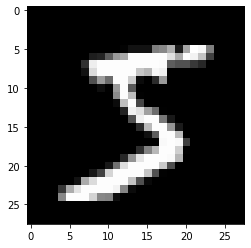

In [0]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray") #loading the first image of the x_train set, size 28x28, grayscale
x_train.shape #printing the shape of x_train

In [0]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid)) #mapping the sets as torch tensors
n,c = x_train.shape #making the dimensions of x_train as variables n and c
x_train.shape, y_train.min(), y_train.max() #printing x_train's shape, y_train's minimum and maximum value. All implemented in torch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64 #batch size
train_ds = TensorDataset(x_train, y_train) #dataset wrapping tensors 
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) #databunch 

In [0]:
x,y = next(iter(data.train_dl)) #iterate through data
x.shape,y.shape #check the shape --> we can see the data is now into batches of size 64

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module): #Module model 
    def __init__(self):
        super().__init__() #calling superclass' methods
        self.lin = nn.Linear(784, 10, bias=True) #Linear layer of size 784, 10

    def forward(self, xb): return self.lin(xb) #return the linear

In [0]:
model = Mnist_Logistic().cuda() #applying to GPU

In [0]:
model #check the model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model.lin #check the Linear layer

Linear(in_features=784, out_features=10, bias=True)

In [0]:
model(x).shape #check the shape of data being processed at once (one batch)

torch.Size([64, 10])

In [0]:
[p.shape for p in model.parameters()] #check the parameters

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2 #learning rate

In [0]:
loss_func = nn.CrossEntropyLoss() #cross entropy as loss function

In [0]:
def update(x,y,lr): #updating learning
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward() #backpropagation
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl] #loss results

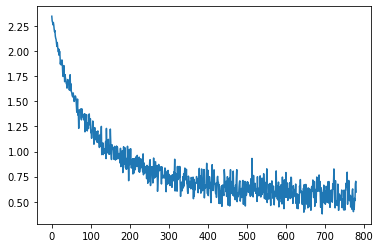

In [0]:
plt.plot(losses); #let's see how it looks

In [0]:
class Mnist_NN(nn.Module): #now let's make another model with 2 linear layers
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda() #on GPU

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl] #calculate the loss

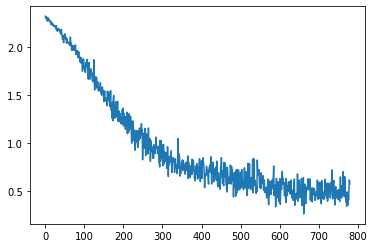

In [0]:
plt.plot(losses); #see it

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr): #update with Adam optimizer
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl] #calculate losses again

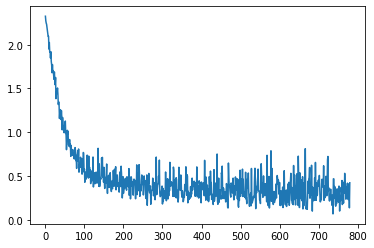

In [0]:
plt.plot(losses);

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy) #load our model to fit our data

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


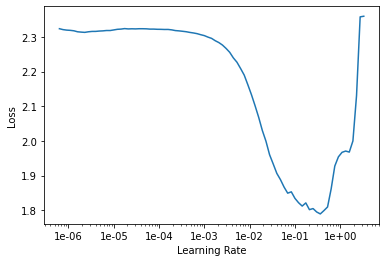

In [0]:
learn.lr_find() #find the learning rate
learn.recorder.plot() #plot it

In [0]:
learn.fit_one_cycle(1, 1e-2) #fit on the best slice

epoch,train_loss,valid_loss,accuracy,time
0,0.143194,0.130783,0.963400,00:03


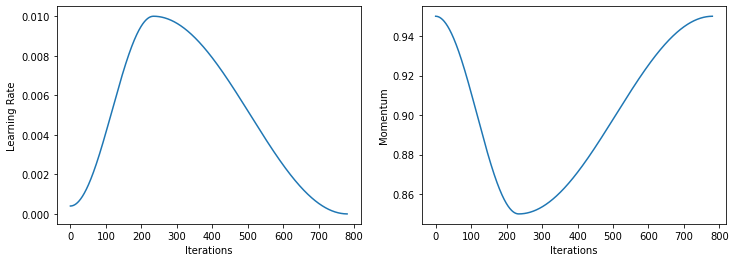

In [0]:
learn.recorder.plot_lr(show_moms=True) #showing momentum 

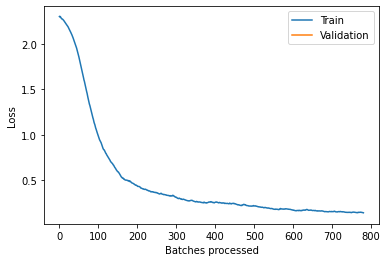

In [0]:
learn.recorder.plot_losses() #showing losses

## fin